In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D, Dense, Activation, MaxPooling2D, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.metrics import Recall, Precision, AUC, Accuracy, F1Score
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_path = r'/kaggle/input/plantdisease/PlantVillage'
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


## Dataset Exploration

In [5]:
classes_count = {}
total_count = 0
for clas in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path,clas)
    
    if os.path.isdir(class_path):
        classes_count[clas] = len(os.listdir(class_path))
        total_count += classes_count[clas]
    

for clas,cnt in classes_count.items():
    print(f'{clas} : {cnt} images.' )

print('Total number of images: ',total_count)
print('Total number of classes: ', len(classes_count))

Pepper__bell___Bacterial_spot : 997 images.
Potato___healthy : 152 images.
Tomato_Leaf_Mold : 952 images.
Tomato__Tomato_YellowLeaf__Curl_Virus : 3209 images.
Tomato_Bacterial_spot : 2127 images.
Tomato_Septoria_leaf_spot : 1771 images.
Tomato_healthy : 1591 images.
Tomato_Spider_mites_Two_spotted_spider_mite : 1676 images.
Tomato_Early_blight : 1000 images.
Tomato__Target_Spot : 1404 images.
Pepper__bell___healthy : 1478 images.
Potato___Late_blight : 1000 images.
Tomato_Late_blight : 1909 images.
Potato___Early_blight : 1000 images.
Tomato__Tomato_mosaic_virus : 373 images.
Total number of images:  20639
Total number of classes:  15


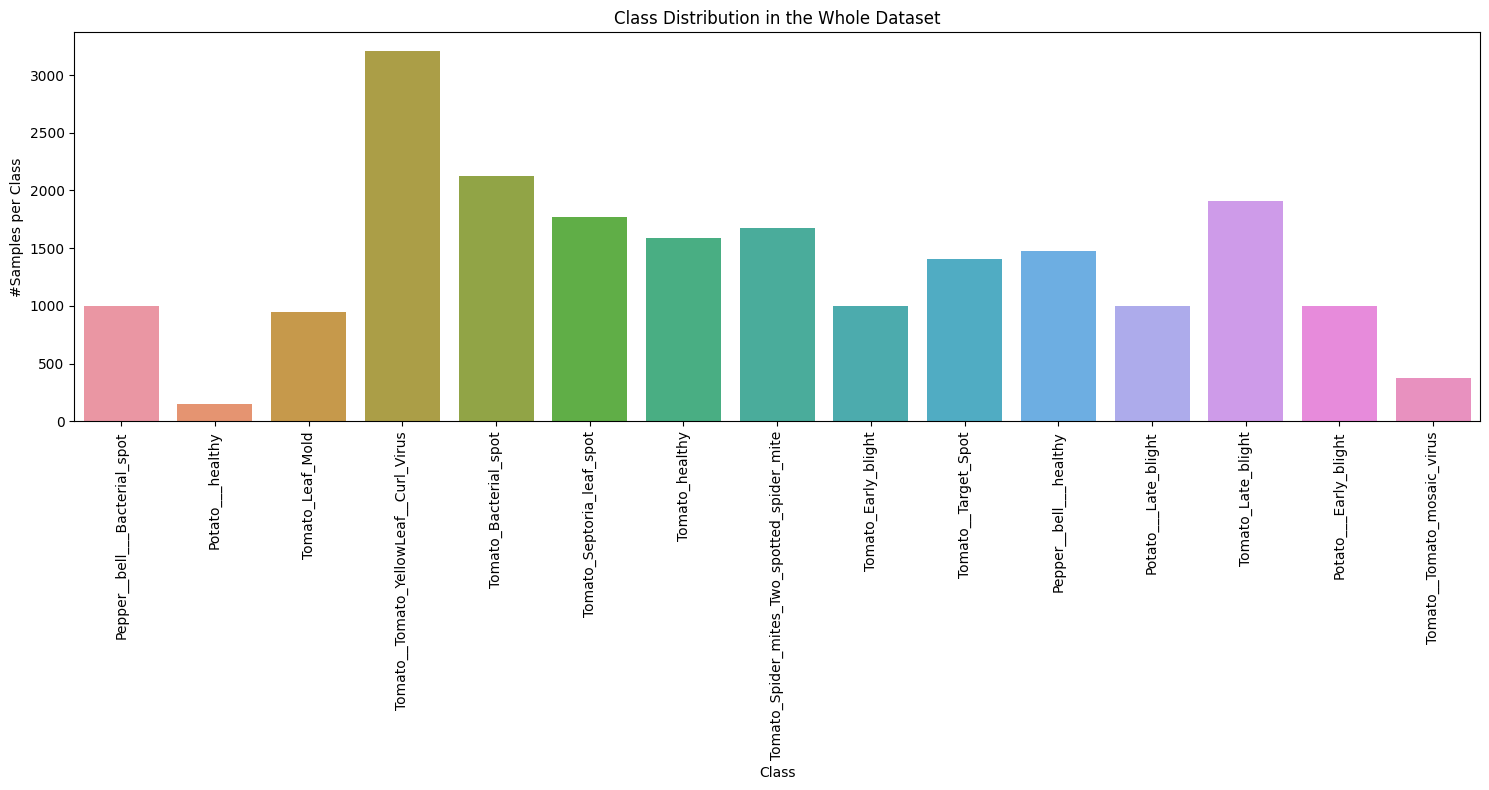

In [30]:
plt.figure(figsize=(15,8))
sns.barplot(x=list(classes_count.keys()), y=list(classes_count.values()))
plt.title('Class Distribution in the Whole Dataset')
plt.xticks(rotation = 90)
plt.xlabel('Class')
plt.ylabel('#Samples per Class')
plt.tight_layout()
plt.show()

Notice that our dataset is imbalanced between classes

### take a glance

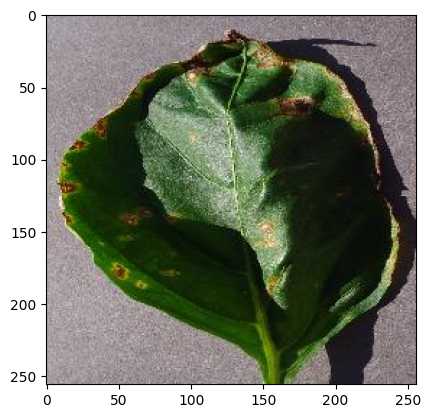

In [31]:
first_class_path = os.path.join(dataset_path,os.listdir(dataset_path)[0])
sample_path = os.path.join(first_class_path,os.listdir(first_class_path)[0])


img = image.load_img(sample_path)
plt.imshow(img)

In [32]:
img.size

(256, 256)

## 

In [33]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical', #for one hot encoding
    subset='training',
    shuffle = True
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle = False
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [34]:
print(train_data.class_indices)

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


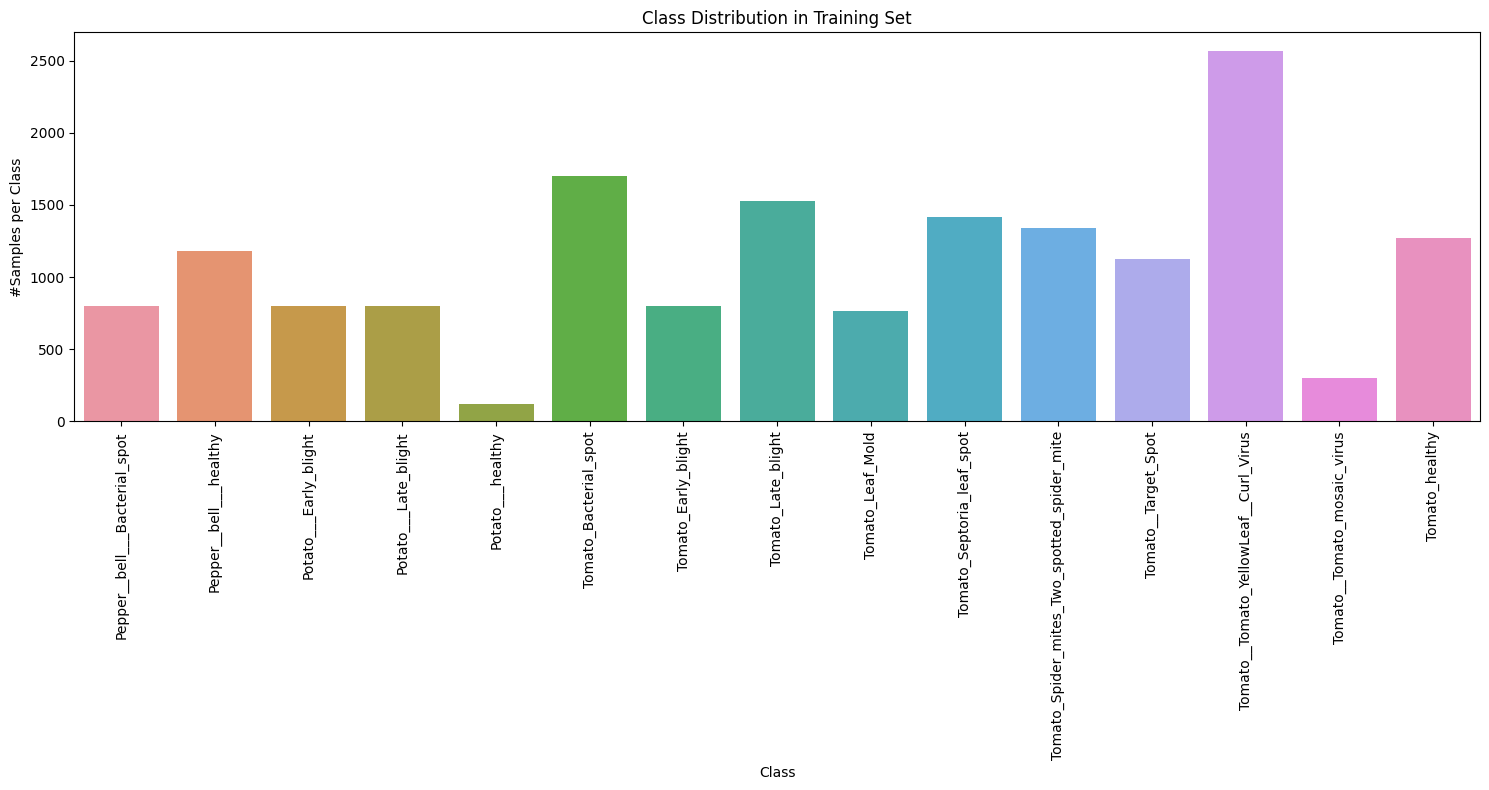

In [35]:
class_counts = {}
for class_name, class_idx in train_data.class_indices.items():
    class_counts[class_name] = train_data.classes.tolist().count(class_idx)


plt.figure(figsize=(15, 8))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=90)
plt.ylabel('#Samples per Class')
plt.xlabel('Class')
plt.tight_layout()
plt.show()


## Modeling (First trial)

In [58]:
INPUT_SHAPE = (256,256,3)
NUM_CLASSES = 15
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 20
models_results = {}

### Baseline CNN

In [37]:
baseline_CNN = Sequential([

    #block 1
    Conv2D(32,(3,3), padding = 'same', input_shape= INPUT_SHAPE),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    #block 2
    Conv2D(64,(3,3), padding = 'same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    #classifier
    Flatten(),
    Dense(512, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(NUM_CLASSES, activation = 'softmax')

])

baseline_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │     134,218,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,305,231 (512.33 MB)

 Trainable params: 134,305,231 (512.33 MB)

 Non-trainable params: 0 (0.00 B)

#### Training Baseline CNN

In [19]:
baseline_CNN.compile(
    optimizer = Adam(learning_rate = LEARNING_RATE),
    loss = 'categorical_crossentropy',
    metrics=['Precision', 'Recall','accuracy']
)

history = baseline_CNN.fit(
    train_data,
    validation_data = val_data,
    epochs = EPOCHS
)

Epoch 1/10
517/517 [==============================] - 353s 679ms/step - loss: 1.3251 - precision: 0.8053 - recall: 0.5099 - accuracy: 0.6359 - val_loss: 0.5604 - val_precision: 0.8506 - val_recall: 0.7623 - val_accuracy: 0.8057
Epoch 2/10
517/517 [==============================] - 246s 476ms/step - loss: 0.3884 - precision: 0.9060 - recall: 0.8412 - accuracy: 0.8732 - val_loss: 0.5764 - val_precision: 0.8406 - val_recall: 0.7763 - val_accuracy: 0.8052
Epoch 3/10
517/517 [==============================] - 243s 471ms/step - loss: 0.1575 - precision: 0.9572 - recall: 0.9397 - accuracy: 0.9482 - val_loss: 0.5336 - val_precision: 0.8722 - val_recall: 0.8331 - val_accuracy: 0.8537
Epoch 4/10
517/517 [==============================] - 249s 482ms/step - loss: 0.0839 - precision: 0.9763 - recall: 0.9698 - accuracy: 0.9729 - val_loss: 0.5945 - val_precision: 0.8588 - val_recall: 0.8367 - val_accuracy: 0.8440
Epoch 5/10
517/517 [==============================] - 253s 489ms/step - loss: 0.0522 - p

In [38]:
def plot_training_history(history, title):

    plt.figure(figsize=(14, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


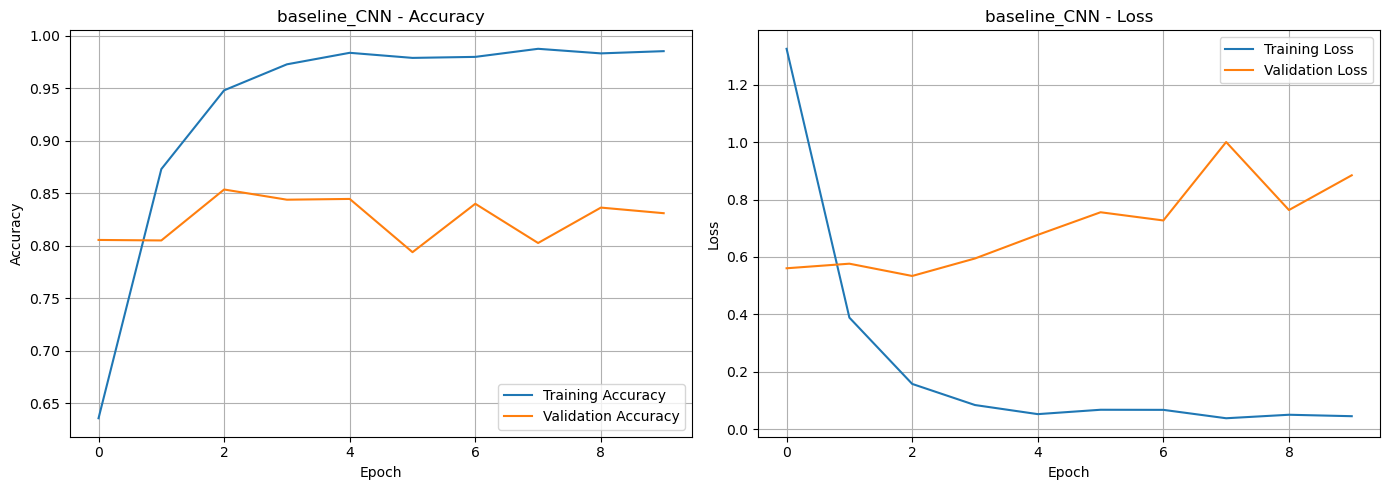

In [28]:
plot_training_history(history, 'baseline_CNN')

the val loss is significantly higher than the training loss, **Overfitting**

In [26]:
y_pred_labels = baseline_CNN.predict(val_data)
y_pred = np.argmax(y_pred_labels,axis = 1)
y_val = val_data.classes 

print(classification_report(y_val, y_pred, target_names= val_data.class_indices.keys()))

129/129 [==============================] - 18s 131ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.58      0.73       199
                     Pepper__bell___healthy       0.93      0.89      0.91       295
                      Potato___Early_blight       0.70      0.98      0.82       200
                       Potato___Late_blight       0.82      0.65      0.73       200
                           Potato___healthy       0.80      0.40      0.53        30
                      Tomato_Bacterial_spot       0.93      0.94      0.93       425
                        Tomato_Early_blight       0.54      0.75      0.63       200
                         Tomato_Late_blight       0.85      0.79      0.82       381
                           Tomato_Leaf_Mold       0.93      0.73      0.81       190
                  Tomato_Septoria_leaf_spot       0.66      0.82      0.73       354
Tomato

#### Observations
- **Our dataset is imbalanced, so:**
   1. We will use weighted f1-score as our main metric
   2. We will add class weights
- **We have overfitting, so:**
   1. Let's add dropout and batchnorm

## Modelling (Enhanced)

#### Let's add some Augemntations

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    brightness_range=[0.5, 1.5],
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2,
)

val_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    validation_split = 0.2,
)

train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle = True
)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle = False
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


#### Let's compute class weights

In [7]:
labels = train_data.classes
class_indices = train_data.class_indices
class_labels = np.array(list(class_indices.values()))

class_weight_values = compute_class_weight(
    class_weight = 'balanced',
    classes = class_labels,
    y = labels
    
)
class_weight_dict = dict(zip(class_labels, class_weight_values))
class_weight_dict


{0: 1.379782790309106,
 1: 0.9307410538179769,
 2: 1.3763333333333334,
 3: 1.3763333333333334,
 4: 9.025136612021859,
 5: 0.6469251860556209,
 6: 1.3763333333333334,
 7: 0.7205933682373473,
 8: 1.4449693788276465,
 9: 0.7770406963067513,
 10: 0.8210787969177231,
 11: 0.9795966785290628,
 12: 0.4289313076223867,
 13: 3.6824972129319957,
 14: 0.8649384655669023}

### Training func

In [10]:
def train_model(model, model_name, opt = Adam, lr = LEARNING_RATE, epocs = EPOCHS, train_data = train_data, val_data = val_data):
    checkpoint_dir = os.path.join('models',model_name)
    os.makedirs(checkpoint_dir,exist_ok = True)


    #callbacks
    checkpoint = ModelCheckpoint(
        os.path.join(checkpoint_dir,f'best_{model_name}.keras'),
        monitor = 'val_F1Score',
        save_best_only = True,
        mode = 'max',
        verbose = 1
    )

    early_stopping = EarlyStopping(
        monitor = 'val_F1Score',
        patience = 5,
        restore_best_weights = True,
        verbose = 1
    )

    #train the model
    model.compile(
        optimizer = opt(learning_rate = lr),
        loss = 'categorical_crossentropy',
        metrics=[
            'accuracy',
            'Precision',
            'Recall',
            F1Score(average='weighted', name='F1Score'),
        ]
    )
    
    history = model.fit(
        train_data,
        validation_data = val_data,
        epochs = epocs,
        class_weight = class_weight_dict,
        callbacks = [checkpoint,early_stopping],
        verbose = 1
    )

    return model,history

    

    

In [56]:
def evaluate_model(model, model_name,val_data = val_data): 
    y_pred_labels = model.predict(val_data)
    y_pred = np.argmax(y_pred_labels,axis = 1)
    y_val = val_data.classes 

    class_names = val_data.class_indices.keys()

    #accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")

    #classification report
    report = classification_report(y_val, y_pred, target_names= class_names, output_dict=True) #to use later for model comparison
    print(classification_report(y_val, y_pred, target_names= class_names))

    #confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return report


In [28]:
def plot_training_history(history, title):

    plt.figure(figsize=(10, 10))
    
    # Plot F1Score
    plt.subplot(3, 2, 1)
    plt.plot(history.history['F1Score'], label='Training F1Score')
    plt.plot(history.history['val_F1Score'], label='Validation F1Score')
    plt.title(f'{title} - F1Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1Score')
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    
    # Plot Precision
    plt.subplot(3, 2, 3)
    plt.plot(history.history['Precision'], label='Training Precision')
    plt.plot(history.history['val_Precision'], label='Validation Precision')
    plt.title(f'{title} - Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    # Plot Recall
    plt.subplot(3, 2, 4)
    plt.plot(history.history['Recall'], label='Training Recall')
    plt.plot(history.history['val_Recall'], label='Validation Recall')
    plt.title(f'{title} - Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(3, 2, 5)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 6)
    plt.axis("off") 
    
    plt.tight_layout()
    plt.show()


### Custom  CNN

In [14]:
custom_cnn = Sequential([

    #block 1
    Conv2D(32,(3,3), padding = 'same', input_shape= INPUT_SHAPE),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    #block 2
    Conv2D(64,(3,3), padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    #block 3
    Conv2D(128,(3,3), padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    #classifier
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation = 'softmax')

])

custom_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,685,199 (128.50 MB)

 Trainable params: 33,683,983 (128.49 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [103]:
custom_model, custom_history = train_model(custom_cnn, "Custom_CNN", epocs = 25)

Epoch 1/25
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - F1Score: 0.8435 - Precision: 0.8795 - Recall: 0.8086 - accuracy: 0.8428 - loss: 0.4620
Epoch 1: val_F1Score improved from -inf to 0.61541, saving model to models/Custom_CNN/best_Custom_CNN.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 317s 585ms/step - F1Score: 0.8435 - Precision: 0.8795 - Recall: 0.8086 - accuracy: 0.8428 - loss: 0.4619 - val_F1Score: 0.6154 - val_Precision: 0.6359 - val_Recall: 0.5898 - val_accuracy: 0.6087 - val_loss: 1.6471
Epoch 2/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - F1Score: 0.8545 - Precision: 0.8897 - Recall: 0.8197 - accuracy: 0.8533 - loss: 0.4239
Epoch 2: val_F1Score improved from 0.61541 to 0.79563, saving model to models/Custom_CNN/best_Custom_CNN.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 284s 542ms/step - F1Score: 0.8545 - Precision: 0.8897 - Recall: 0.8197 - accuracy: 0.8533 - loss: 0.4239 - val_F1Score: 0.7956 - val_Precision: 0.8214 - val_Recall: 0.7855 - val_accuracy: 0.7991 - val_loss: 0.6116
Epoch 3/2

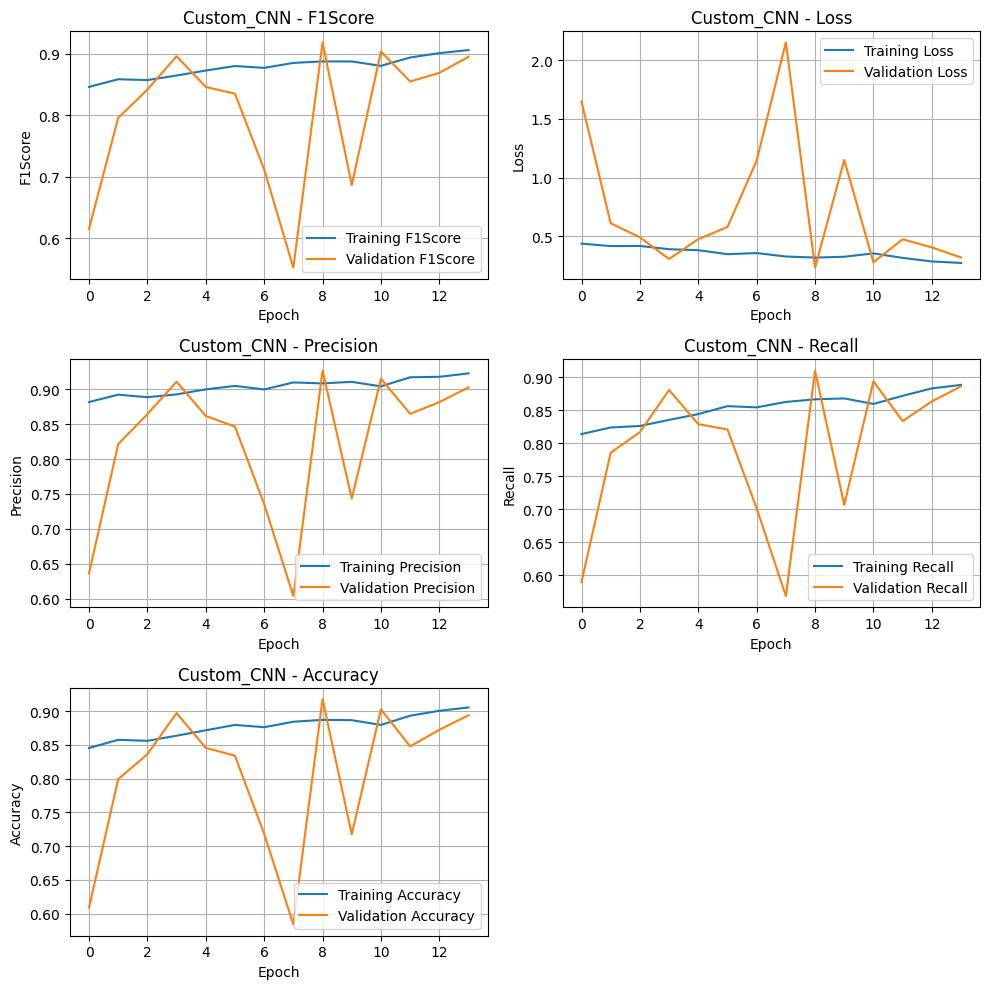

In [104]:
plot_training_history(custom_history,'Custom_CNN')

129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step
Validation Accuracy: 0.9175
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.86      0.92       199
                     Pepper__bell___healthy       0.96      0.97      0.96       295
                      Potato___Early_blight       0.89      0.98      0.94       200
                       Potato___Late_blight       0.77      0.97      0.86       200
                           Potato___healthy       0.67      1.00      0.80        30
                      Tomato_Bacterial_spot       0.97      0.96      0.96       425
                        Tomato_Early_blight       0.93      0.84      0.88       200
                         Tomato_Late_blight       0.95      0.85      0.90       381
                           Tomato_Leaf_Mold       0.96      0.91      0.93       190
                  Tomato_Septoria_leaf_spot       0.93      0.88      0.91     

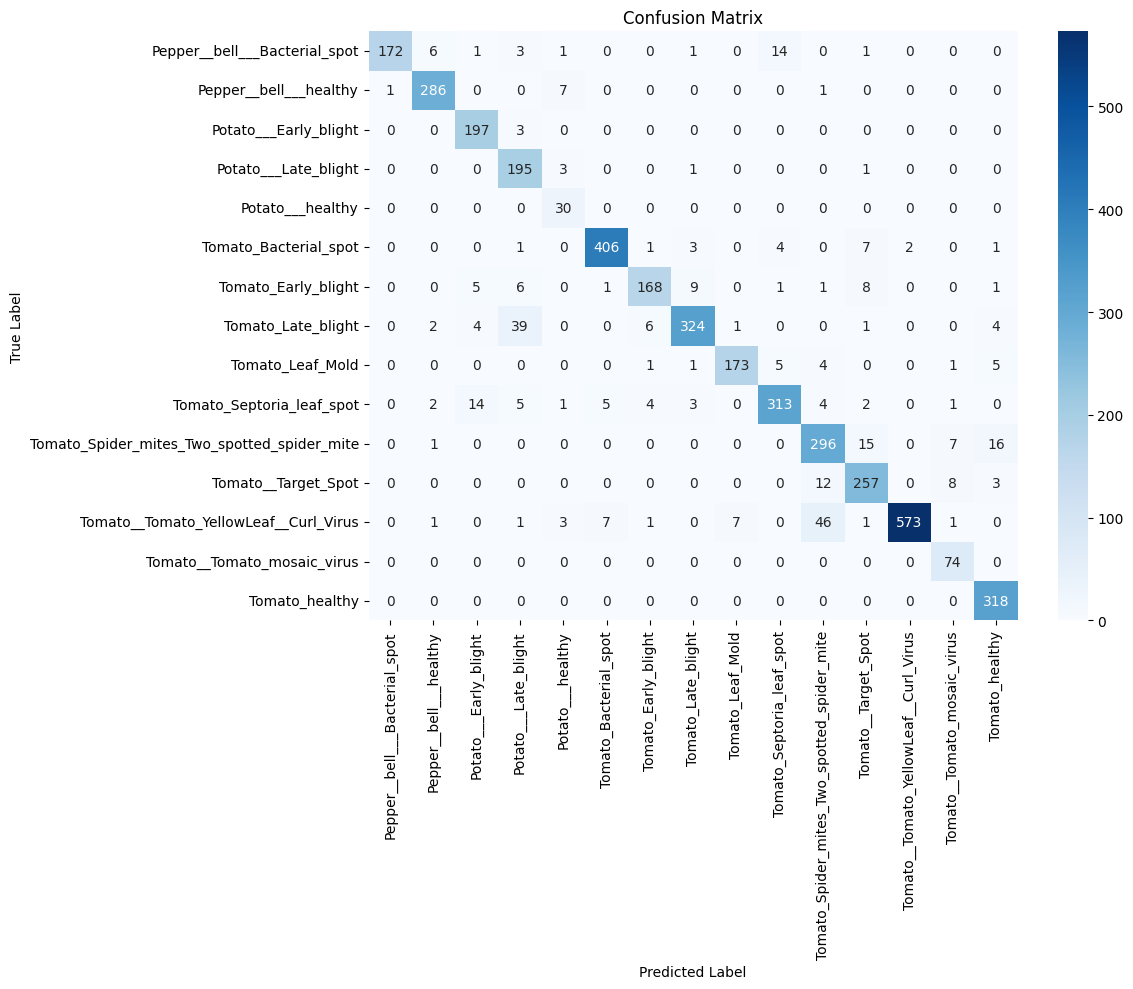

In [105]:
custom_report = evaluate_model(custom_model,'Custom_CNN')
models_results['Custom CNN'] = {
    'accuracy': custom_report['accuracy'],
    'weighted_f1': custom_report['weighted avg']['f1-score']
}

## Using pretrained models

In [46]:
def create_datagen(model, preprocess_input, input_shape):
    train_datagen = ImageDataGenerator(
        preprocessing_function= preprocess_input,
        rescale = None,
        brightness_range=[0.5, 1.5],
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        validation_split = 0.2,
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function= preprocess_input,
        rescale = None,
        validation_split = 0.2,
    )
    
    train_data = train_datagen.flow_from_directory(
        dataset_path,
        target_size= input_shape,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle = True
    )
    
    val_data = val_datagen.flow_from_directory(
        dataset_path,
        target_size= input_shape,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle = False
    )

    return train_data, val_data



In [47]:
def create_transfer_learning_model(base_model_name, img_size = 256, trainable=False):

    input_shape = (img_size, img_size, 3)
    
    if base_model_name == 'VGG16':
        train_data,val_data = create_datagen(VGG16, vgg_preprocess, (img_size,img_size))
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        train_data,val_data = create_datagen(ResNet50, resnet_preprocess, (img_size,img_size))
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'InceptionV3':
        train_data,val_data = create_datagen(InceptionV3, inception_preprocess, (img_size,img_size))
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)


    base_model.trainable = trainable

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CLASSES, activation = 'softmax')(x)

    
    model = Model(inputs=base_model.input, outputs=x)

    return model, train_data, val_data

    

### ResNet50

In [48]:
model_name = 'ResNet50'
resnet_model,resnet_train_data,resnet_val_data = create_transfer_learning_model(model_name, 224, False)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [49]:
resnet_model, resnet_history = train_model(resnet_model, model_name, train_data = resnet_train_data, val_data = resnet_val_data)

Epoch 1/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - F1Score: 0.6538 - Precision: 0.8130 - Recall: 0.4974 - accuracy: 0.6478 - loss: 1.1318
Epoch 1: val_F1Score improved from -inf to 0.90584, saving model to models/ResNet50/best_ResNet50.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 250s 446ms/step - F1Score: 0.6540 - Precision: 0.8131 - Recall: 0.4977 - accuracy: 0.6480 - loss: 1.1310 - val_F1Score: 0.9058 - val_Precision: 0.9334 - val_Recall: 0.8809 - val_accuracy: 0.9051 - val_loss: 0.2925
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - F1Score: 0.8879 - Precision: 0.9250 - Recall: 0.8493 - accuracy: 0.8871 - loss: 0.3533
Epoch 2: val_F1Score did not improve from 0.90584
517/517 ━━━━━━━━━━━━━━━━━━━━ 219s 418ms/step - F1Score: 0.8879 - Precision: 0.9250 - Recall: 0.8493 - accuracy: 0.8871 - loss: 0.3532 - val_F1Score: 0.8946 - val_Precision: 0.9132 - val_Recall: 0.8775 - val_accuracy: 0.8930 - val_loss: 0.3046
Epoch 3/20
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - F1Score: 0.9105 - 

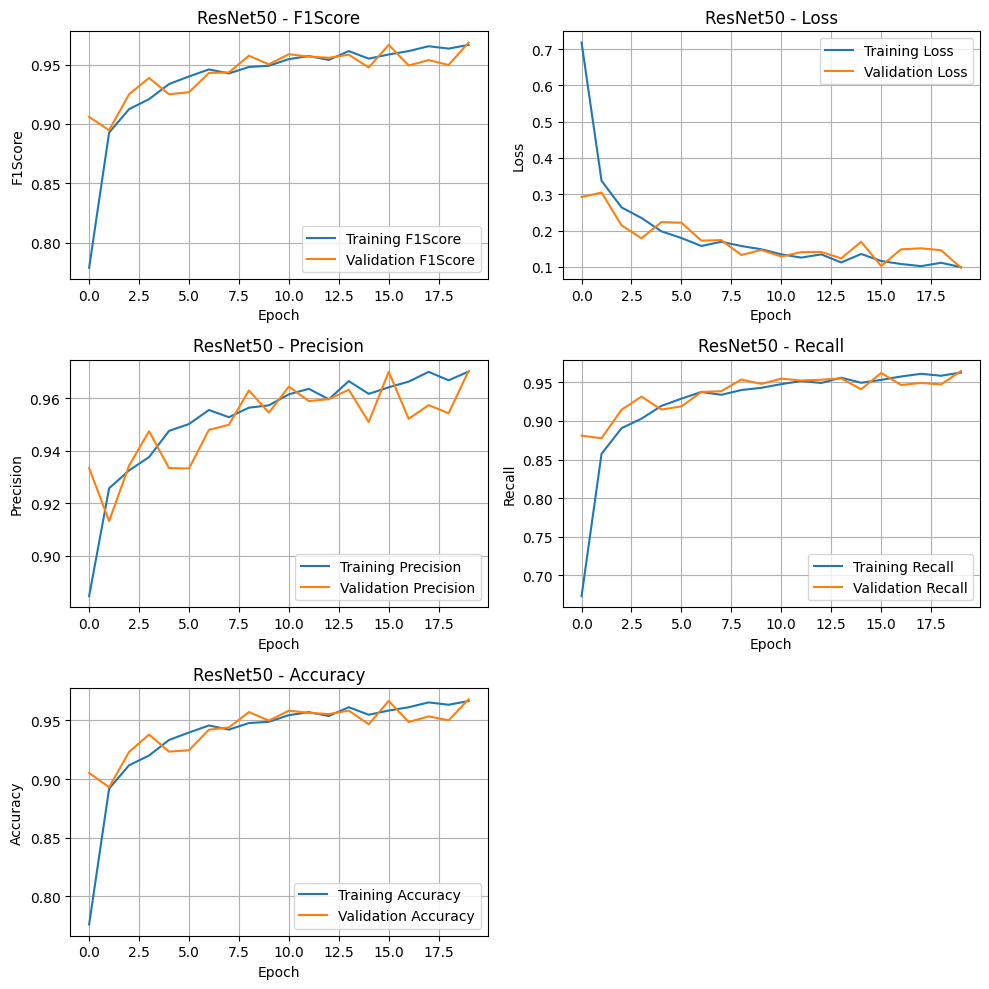

In [50]:
plot_training_history(resnet_history,model_name)

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
Validation Accuracy: 0.9680
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      1.00      0.99       199
                     Pepper__bell___healthy       1.00      0.99      0.99       295
                      Potato___Early_blight       0.99      0.99      0.99       200
                       Potato___Late_blight       0.99      0.96      0.97       200
                           Potato___healthy       0.83      0.97      0.89        30
                      Tomato_Bacterial_spot       1.00      0.96      0.98       425
                        Tomato_Early_blight       0.95      0.93      0.94       200
                         Tomato_Late_blight       0.99      0.97      0.98       381
                           Tomato_Leaf_Mold       0.98      0.97      0.97       190
                  Tomato_Septoria_leaf_spot       0.99      0.97      0.98    

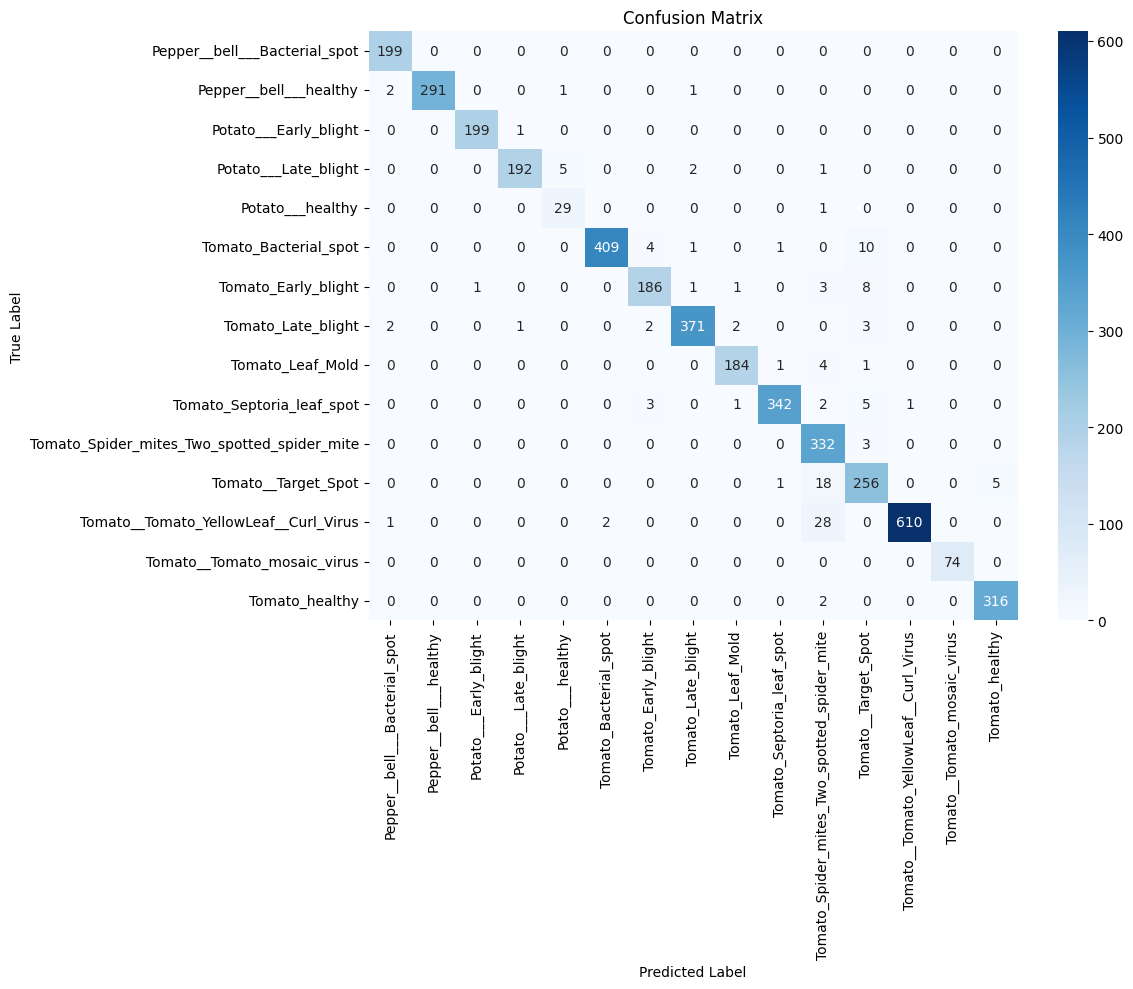

In [60]:
resnet_report = evaluate_model(resnet_model,model_name, val_data = resnet_val_data)
models_results[model_name] = {
    'accuracy': resnet_report['accuracy'],
    'weighted_f1': resnet_report['weighted avg']['f1-score']
}

### VGG16

In [61]:
model_name = 'VGG16'
vgg_model,vgg_train_data,vgg_val_data = create_transfer_learning_model(model_name, 224, False)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [62]:
vgg_model, vgg_history = train_model(vgg_model, model_name, train_data = vgg_train_data, val_data = vgg_val_data)

Epoch 1/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - F1Score: 0.5020 - Precision: 0.7357 - Recall: 0.3130 - accuracy: 0.4979 - loss: 1.6688
Epoch 1: val_F1Score improved from -inf to 0.85429, saving model to models/VGG16/best_VGG16.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 250s 452ms/step - F1Score: 0.5023 - Precision: 0.7359 - Recall: 0.3134 - accuracy: 0.4982 - loss: 1.6678 - val_F1Score: 0.8543 - val_Precision: 0.8950 - val_Recall: 0.7897 - val_accuracy: 0.8508 - val_loss: 0.4620
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - F1Score: 0.8064 - Precision: 0.8820 - Recall: 0.7278 - accuracy: 0.8039 - loss: 0.5950
Epoch 2: val_F1Score improved from 0.85429 to 0.88391, saving model to models/VGG16/best_VGG16.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 437ms/step - F1Score: 0.8064 - Precision: 0.8820 - Recall: 0.7279 - accuracy: 0.8039 - loss: 0.5949 - val_F1Score: 0.8839 - val_Precision: 0.9217 - val_Recall: 0.8513 - val_accuracy: 0.8833 - val_loss: 0.3598
Epoch 3/20
517/517 ━━━━━━━━━━

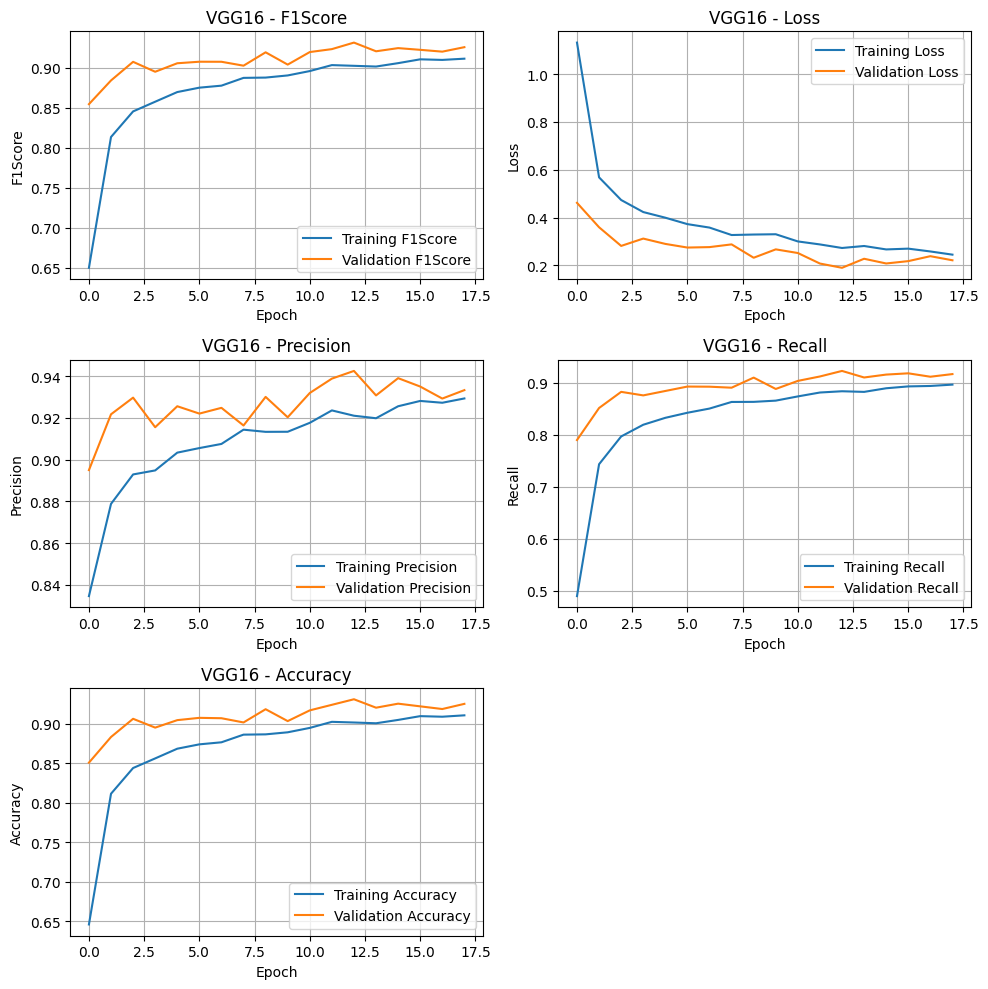

In [63]:
plot_training_history(vgg_history,model_name)

129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step
Validation Accuracy: 0.9311
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.95      0.94       199
                     Pepper__bell___healthy       0.96      0.97      0.96       295
                      Potato___Early_blight       0.99      0.99      0.99       200
                       Potato___Late_blight       0.99      0.91      0.95       200
                           Potato___healthy       0.83      1.00      0.91        30
                      Tomato_Bacterial_spot       0.94      0.97      0.96       425
                        Tomato_Early_blight       0.89      0.85      0.87       200
                         Tomato_Late_blight       0.95      0.93      0.94       381
                           Tomato_Leaf_Mold       0.88      0.94      0.91       190
                  Tomato_Septoria_leaf_spot       0.87      0.94      0.90    

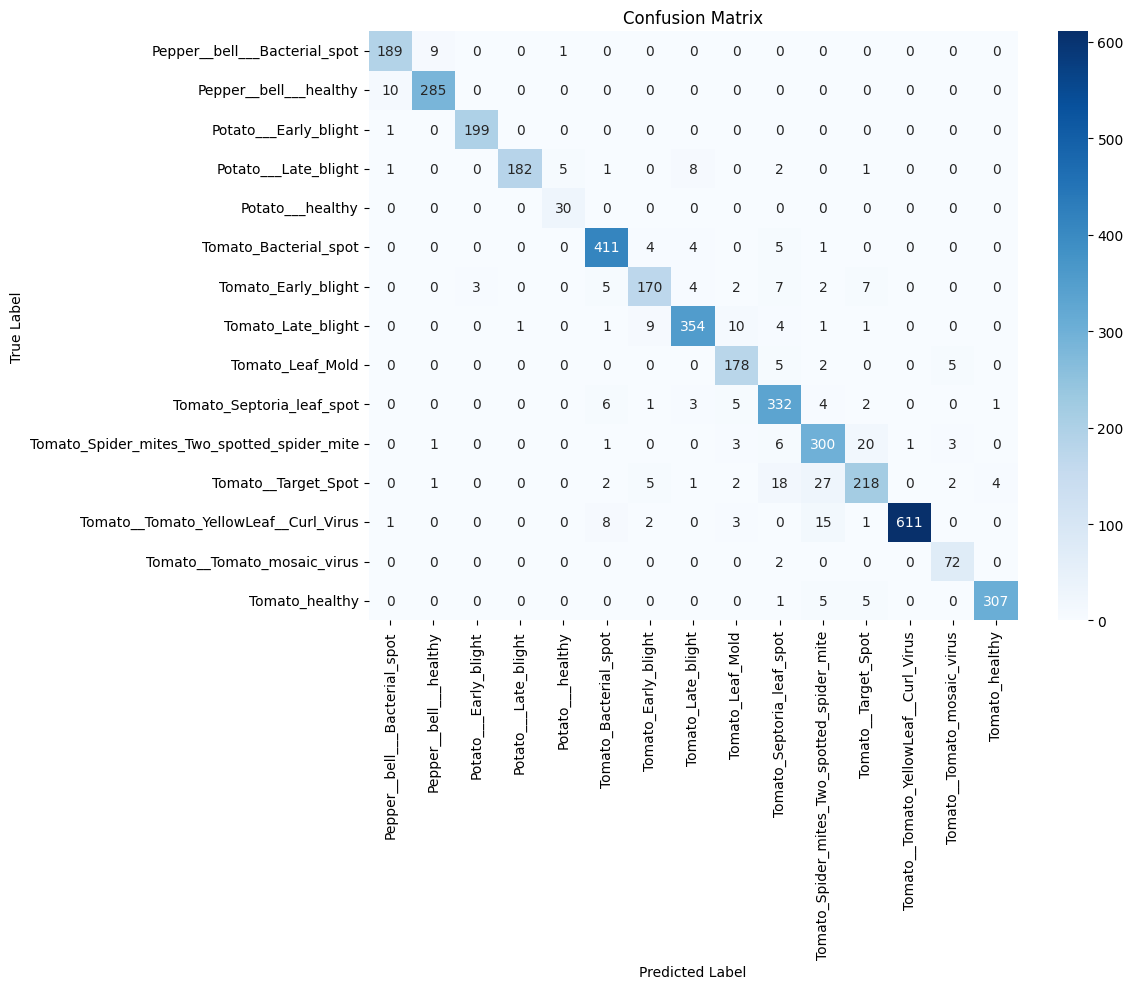

In [64]:
vgg_report = evaluate_model(vgg_model,model_name, val_data = vgg_val_data)
models_results[model_name] = {
    'accuracy': vgg_report['accuracy'],
    'weighted_f1': vgg_report['weighted avg']['f1-score']
}

### InceptionV3

In [97]:
model_name = 'InceptionV3'
incept_model,incept_train_data,incept_val_data = create_transfer_learning_model(model_name, 299, False)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [98]:
incept_model, incept_history = train_model(incept_model, model_name, train_data = incept_train_data, val_data = incept_val_data)

Epoch 1/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - F1Score: 0.5743 - Precision: 0.7618 - Recall: 0.4015 - accuracy: 0.5676 - loss: 1.4290
Epoch 1: val_F1Score improved from -inf to 0.82867, saving model to models/InceptionV3/best_InceptionV3.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 465s 843ms/step - F1Score: 0.5745 - Precision: 0.7619 - Recall: 0.4018 - accuracy: 0.5678 - loss: 1.4282 - val_F1Score: 0.8287 - val_Precision: 0.8945 - val_Recall: 0.7528 - val_accuracy: 0.8292 - val_loss: 0.5222
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - F1Score: 0.8076 - Precision: 0.8733 - Recall: 0.7375 - accuracy: 0.8035 - loss: 0.6173
Epoch 2: val_F1Score improved from 0.82867 to 0.84150, saving model to models/InceptionV3/best_InceptionV3.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 417s 795ms/step - F1Score: 0.8076 - Precision: 0.8733 - Recall: 0.7375 - accuracy: 0.8035 - loss: 0.6172 - val_F1Score: 0.8415 - val_Precision: 0.8850 - val_Recall: 0.7804 - val_accuracy: 0.8350 - val_loss: 0.5033
Epoch

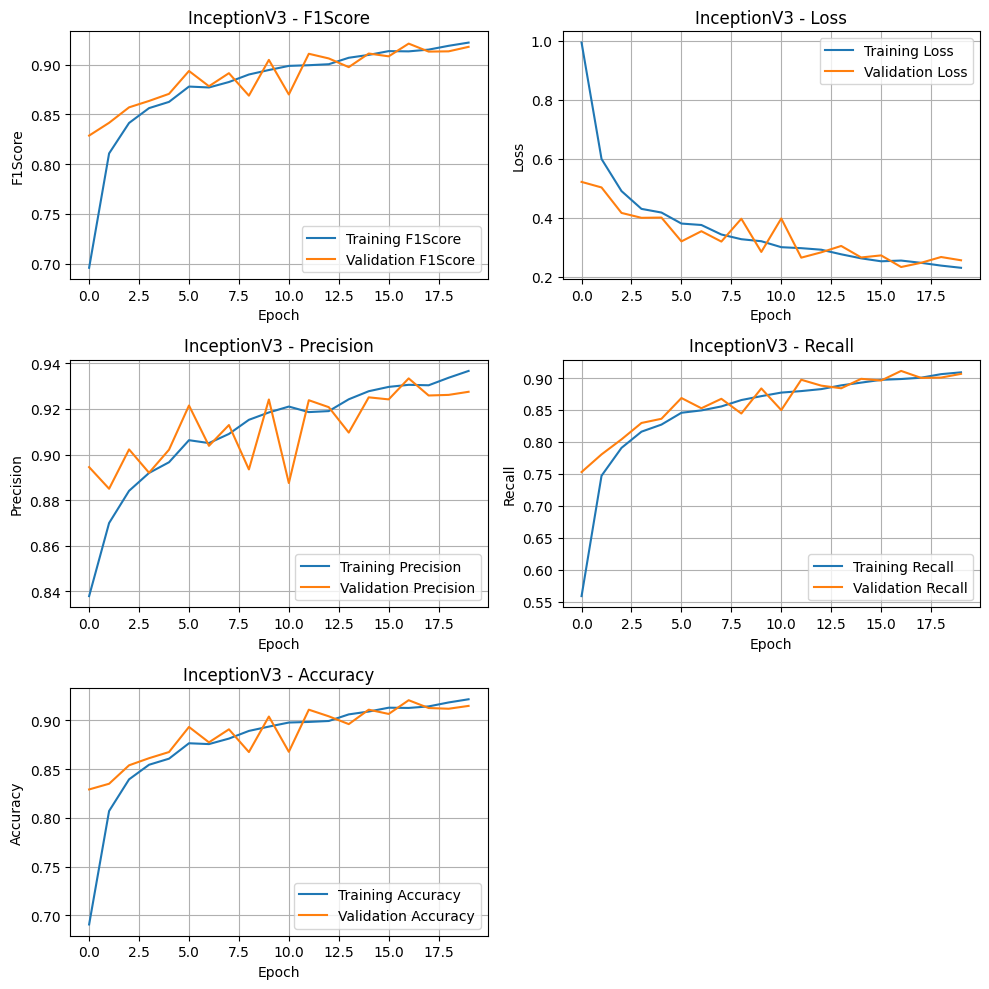

In [99]:
plot_training_history(incept_history,model_name)

129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 189ms/step
Validation Accuracy: 0.9207
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.95      0.97      0.96       199
                     Pepper__bell___healthy       0.97      0.99      0.98       295
                      Potato___Early_blight       0.92      0.98      0.95       200
                       Potato___Late_blight       0.94      0.91      0.92       200
                           Potato___healthy       0.84      0.87      0.85        30
                      Tomato_Bacterial_spot       0.97      0.90      0.93       425
                        Tomato_Early_blight       0.91      0.69      0.79       200
                         Tomato_Late_blight       0.93      0.94      0.93       381
                           Tomato_Leaf_Mold       0.83      0.95      0.88       190
                  Tomato_Septoria_leaf_spot       0.92      0.85      0.88   

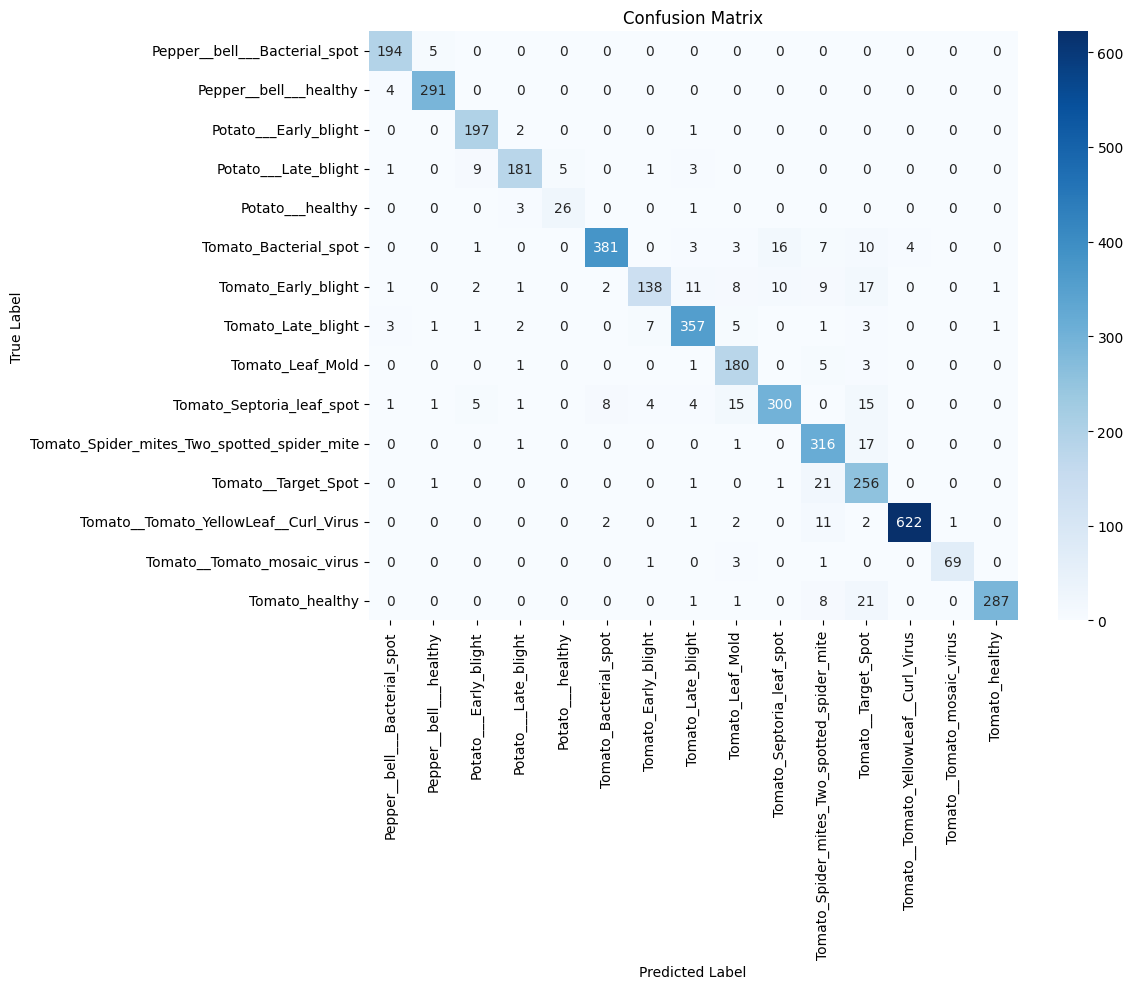

In [100]:
inception_report = evaluate_model(incept_model,model_name, val_data = incept_val_data)
models_results[model_name] = {
    'accuracy': inception_report['accuracy'],
    'weighted_f1': inception_report['weighted avg']['f1-score']
}

## Models Comparison

In [106]:
model_names = list(models_results.keys())
accuracies = [models_results[model]['accuracy'] for model in model_names]
f1_scores = [models_results[model]['weighted_f1'] for model in model_names]

results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Weighted F1-Score': f1_scores
})

print("Model Comparison:")
results_df

Model Comparison:


,Model,Accuracy,Weighted F1-Score
0,Custom CNN,0.917516,0.918295
1,ResNet50,0.967977,0.968475
2,VGG16,0.931101,0.931195
3,InceptionV3,0.920670,0.920998


In [102]:
best_idx = np.argmax(f1_scores)
print(f"Best model: {best_model}")

Best model: ResNet50
